In [1]:
from torchvision import transforms
from torch.utils import data
import numpy as np
import argparse
from transformers import AutoModel, AutoTokenizer, MambaForCausalLM
import torch
print(torch.__version__, torch.version.cuda)

from models_mamba import vim_base_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_middle_cls_token_div2
from mamba_lrp.model.vision_mamba import ModifiedVisionMamba

from huggingface_hub import hf_hub_download

/home/matteo/miniforge3/envs/vimLRP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.8.0+cu128 12.8


/home/matteo/miniforge3/envs/vimLRP/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/matteo/miniforge3/envs/vimLRP/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Dataset Loading

In [2]:
DATASET_ROOT = './CUB/DATASET/CUB_200_2011'
DATASET_VALIDATION_RANDOM_SEED = 123
BATCH_SIZE = 6
DATASET_WORK_NUMBER = 8
DATASET_SPLIT_RATIO = 0.9

In [3]:
from DatasetLoader.cub import CUB

trans_train = transforms.Compose([
    # A SCELTA NOSTRA AUGUMENTATION
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(30),
    
    # ATTENZIONE QUA NON DOVREBBE SERIVIRE IL RESIZE (?)
    # transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trans_test = transforms.Compose([
    # ATTENZIONE QUA NON DOVREBBE SERIVIRE IL RESIZE (?)
    transforms.Resize((224, 224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# create dataset
train_data = CUB(DATASET_ROOT, 'train', DATASET_SPLIT_RATIO, DATASET_VALIDATION_RANDOM_SEED, transform=trans_train)
valid_data = CUB(DATASET_ROOT, 'valid', DATASET_SPLIT_RATIO, DATASET_VALIDATION_RANDOM_SEED, transform=trans_test)
test_data = CUB(DATASET_ROOT, 'test', 0, 0, transform=trans_test)

print("Train: {}".format(len(train_data)))
print("Valid: {}".format(len(valid_data)))
print("Test: {}".format(len(test_data)))

Train: 5395
Valid: 599
Test: 5794


In [4]:
from matplotlib import pyplot as plt

def imshow(image, label, ax=None, normalize=True):
    """show single along with label on an ax"""
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(label)

    return ax


def show_samples(images, labels, nrows=2, ncols=3, title=None, normalize=True):
    """ show multiple samples

    args:
        nrows (int, optional): number of row
        ncols (int, optional): number of column
        title (str, optional): title.
        normalize (bool, optional): whether the images are normalized
    """
    fig, axes = plt.subplots(nrows, ncols, facecolor='#ffffff', dpi=100)

    # .flat: to map samples to multi-dimensional axes
    for (ax, image, label) in zip(axes.flat, images, labels):
        ax = imshow(image, label, ax, normalize)

    fig.suptitle(title)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.85, hspace=0.3)
    plt.show()
    

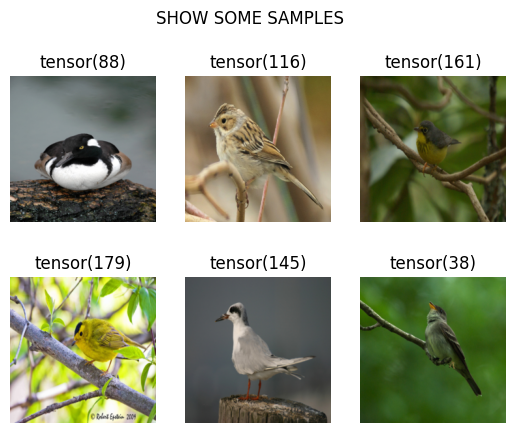

In [5]:
# show samples
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
images, labels = next(iter(train_loader))
show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME SAMPLES')

In [6]:
# create dataloader
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=DATASET_WORK_NUMBER)
valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=DATASET_WORK_NUMBER)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=DATASET_WORK_NUMBER)

# Model creation (work in progress)

#### parameters that were removed from previous versions of Mamba-ssm (and default values):
- bimamba_type (='v2' in VisionMamba, =False in Mamba-ssm)
- if_divide_out (=False)
- init_layer_scale (=None)

In [7]:
from huggingface_hub import list_repo_files
from einops import repeat
files = list_repo_files("hustvl/Vim-base-midclstok")
print(files)

['.gitattributes', 'README.md', 'vim_b_midclstok_81p9acc.pth']


In [8]:
model = vim_base_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_middle_cls_token_div2(pretrained=False)

checkpoint_path = hf_hub_download(repo_id="hustvl/Vim-base-midclstok", filename="vim_b_midclstok_81p9acc.pth")

torch.serialization.add_safe_globals([argparse.Namespace])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load the model's weights

checkpoint = torch.load(checkpoint_path)
status = model.load_state_dict(checkpoint['model'], strict=False)

#assert len(status.missing_keys) == 0


print(device)
model.to(device)
model.eval()


modified_model = ModifiedVisionMamba(model, zero_bias=True)
modified_model.eval()

#pretrained_embeddings = model.embeddings

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
cuda
> /media/matteo/SSD/Data/UNI/4year/DeepLearning/mamba/MambaLRP/mamba_lrp/model/vision_mamba.py(235)__init__()
    234             import ipdb; ipdb.set_trace()
--> 235             self.A_b_log = mamba.A_b_log
    236           

AttributeError: 'Mamba' object has no attribute 'A_b_log'

In [ ]:
from mamba_lrp.lrp.utils import vision_relevance_propagation

In [ ]:
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# get patch embeddings (Tensor), shape: (B, num_patches, embed_dim)
embeddings = modified_model.patch_embed(images)
#embeddings = model.patch_embed(images)

R, prediction, logits = vision_relevance_propagation(
    model = modified_model,
    embeddings = embeddings,
    targets = labels,
    n_classes = 200
)

AttributeError: 'ModifiedMamba' object has no attribute 'A_b_log'